In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))
Pkg.instantiate()

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `ssh://git@github.com/JuliaRegistries/General.git`


In [2]:
using LinearAlgebra
using QPControl
using QPControl.Trajectories
using RigidBodyDynamics
using RigidBodyDynamics.PDControl
using RigidBodyDynamics.Contact
using StaticArrays
using AtlasRobot
using Test
using RigidBodySim
using MathOptInterface
using OSQP.MathOptInterfaceOSQP: OSQPSettings
const MOI = MathOptInterface
using OSQP
using QPWalkingControl
using PlanarConvexHulls
using Rotations
BLAS.set_num_threads(1)

┌ Info: Recompiling stale cache file /home/twan/.julia/compiled/v1.1/QPControl/8tP2B.ji for QPControl [d1d18edd-2826-5709-814b-0b0c7d0d034b]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/twan/.julia/compiled/v1.1/RigidBodySim/s3FmJ.ji for RigidBodySim [e61f16d8-a6b7-5689-8d03-627c2b27ebce]
└ @ Base loading.jl:1184


HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/29d4a42ceb6d03d53ba5feb8981c0eb5bceb5139-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/29d4a42ceb6d03d53ba5feb8981c0eb5bceb5139-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

┌ Info: Recompiling stale cache file /home/twan/.julia/compiled/v1.1/QPWalkingControl/1h0cg.ji for QPWalkingControl [0b169a85-4a4a-588b-8c74-4a8044adc824]
└ @ Base loading.jl:1184


In [3]:
if !(@isdefined mechanism)
#     contactmodel = SoftContactModel(hunt_crossley_hertz(k = 0.8e6), ViscoelasticCoulombModel(0.8, 10e3, 100.))
    mechanism = AtlasRobot.mechanism(add_flat_ground=true)#, contactmodel=contactmodel);
end

# static contact information
soleframes = add_sole_frames!(mechanism)
foot_polygons = make_foot_polygons(mechanism, soleframes; num_extreme_points=4);

# body lookup
feet = findbody.(Ref(mechanism), ["l_foot", "r_foot"])
pelvis = findbody(mechanism, "pelvis");

In [4]:
# create low level controller
lowlevel = let
    optimizer = OSQP.Optimizer()
    MOI.set(optimizer, OSQPSettings.Verbose(), false)
    MOI.set(optimizer, OSQPSettings.EpsAbs(), 1e-5)
    MOI.set(optimizer, OSQPSettings.EpsRel(), 1e-5)
    MOI.set(optimizer, OSQPSettings.MaxIter(), 5000)
    MOI.set(optimizer, OSQPSettings.AdaptiveRhoInterval(), 25) # required for deterministic behavior
    lowlevel = MomentumBasedController{4}(mechanism, optimizer,
        floatingjoint = findjoint(mechanism, "pelvis_to_world"));
    for body in bodies(mechanism)
        for point in RigidBodyDynamics.contact_points(body)
            position = location(point)
            normal = FreeVector3D(default_frame(body), 0.0, 0.0, 1.0)
            μ = point.model.friction.μ
            contact = addcontact!(lowlevel, body, position, normal, μ)
            contact.maxnormalforce[] = 1e6 # TODO
            contact.weight[] = 1e-3
        end
    end
    lowlevel
end;

In [5]:
nominalstate = MechanismState(mechanism)
AtlasRobot.setnominal!(nominalstate)

MechanismState{Float64, Float64, Float64, …}(…)

In [118]:
# ICP stuff
zdes = center_of_mass(nominalstate).v[3] - 0.05
gz = norm(mechanism.gravitational_acceleration)
ω = sqrt(gz / zdes)
icptraj = let
    optimizer = OSQP.Optimizer()
    MOI.set(optimizer, OSQPSettings.Verbose(), false)
    MOI.set(optimizer, OSQPSettings.EpsAbs(), 1e-6)
    MOI.set(optimizer, OSQPSettings.EpsRel(), 1e-8)
    MOI.set(optimizer, OSQPSettings.MaxIter(), 10000)
    MOI.set(optimizer, OSQPSettings.AdaptiveRhoInterval(), 25) # required for deterministic behavior
    max_polygon_sides = 6 # TODO
    num_segments = 6
    ICPTrajectoryGenerator{Float64, max_polygon_sides}(optimizer, num_segments, ω)
end
linear_momentum_controller = ICPController(mechanism, icptraj, zdes);

In [119]:
# walking state machine
statemachine = let
    contacts = Dict(BodyID(body) => contact for (body, contact) in lowlevel.contacts)
    ICPWalkingStateMachine(mechanism, contacts, icptraj)
end;

In [120]:
QPWalkingControl.init_footstep_plan!(statemachine, nominalstate, foot_polygons);

In [121]:
# create high level controller
controller = PushRecoveryController(lowlevel, pelvis, nominalstate, 
    statemachine, collect(values(statemachine.end_effector_controllers)), linear_momentum_controller);

In [122]:
# create visualizer
using MeshCat
using MeshCatMechanisms
using MechanismGeometries

if !(@isdefined gui) || !any(isopen, MeshCatMechanisms.visualizer(gui.visualizer).core.scope.pool.connections)
    pushapplier = PushApplier(mechanism, Point3D(default_frame(pelvis), 0.0, 0.0, 0.0))
    link_colors = Dict(map(foot -> string(foot) => RGBA(0.7f0, 0.7f0, 0.7f0, 0.3f0), feet))
    visuals = URDFVisuals(AtlasRobot.urdfpath(); package_path=[AtlasRobot.packagepath()])#, link_colors=link_colors)
    vis = Visualizer()
    mvis = MechanismVisualizer(mechanism, visuals, vis)
    pvis = PushRecoveryVisualizer(mvis)
    gui = GUI(pvis, usernode=Widget(pushapplier, max_force=100.0, max_Δt=0.3))
    open(gui)
end
copyto!(gui.visualizer, nominalstate);

In [123]:
# create ODEProblem
state = MechanismState(mechanism)
copyto!(state, nominalstate)
Δt = 1 / 500
pcontroller = PeriodicController(similar(velocity(state)), Δt, controller)
damping = JointDamping{Float64}(mechanism, AtlasRobot.urdfpath())
dynamics = Dynamics(mechanism, SumController(similar(velocity(state)), (pcontroller, damping, pushapplier)))
callback = CallbackSet(RealtimeRateLimiter(poll_interval=pi / 100), CallbackSet(gui))
# callback = CallbackSet(gui; max_fps=10)
tspan = (0., 18.)
problem = ODEProblem(dynamics, state, tspan; callback=callback)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 18.0)
u0: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [124]:
QPWalkingControl.init_footstep_plan!(statemachine, nominalstate, foot_polygons);

In [125]:
using Plots
using Plots.PlotMeasures

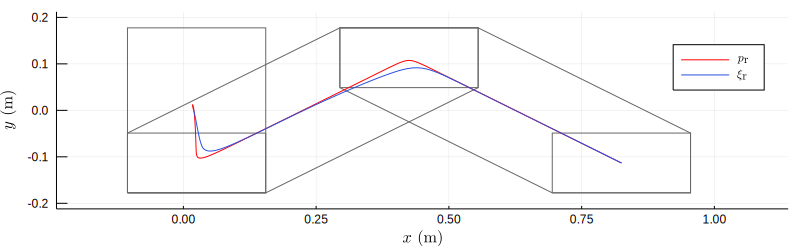

In [135]:
generator = icptraj
Δts = generator.Δts
ts = range(0.0, sum(Δts), length=200)
xlim = [-0.2, 1.1]
ylim = [-0.2, 0.2]
width = 800
height = round(Int, width * diff(ylim)[1] / diff(xlim)[1])
plt = plot(xlabel = raw"$x\textrm{ (m)}$", ylabel = raw"$y\textrm{ (m)}$", xlim = xlim, ylim = ylim, size = (width, height), bottom_margin=10px)
cops = QPWalkingControl.cop.(Ref(generator), ts)

for i in 1 : generator.num_active_segments[]
    hull = statemachine.contact_plan.subfunctions[i].value.support_polygon
    points = push!(copy(vertices(hull)), first(vertices(hull)))
    plot!(plt, getindex.(points, 1), getindex.(points, 2), label="", color=RGB(0.4, 0.4, 0.4))
end
savefig(plt, "/home/twan/Dropbox/thesis/control/figures/overhead_footstep_plan.pdf")
plot!(plt, getindex.(cops, 1), getindex.(cops, 2), label = raw"$p_{\textrm{r}}$", color=RGB(1., 0., 0.))
icps = first.(generator.(ts))
plot!(plt, getindex.(icps, 1), getindex.(icps, 2), label = raw"$\xi_{\textrm{r}}$", color=RGB((42, 81, 224)./255...))
savefig(plt, "/home/twan/Dropbox/thesis/control/figures/overhead_icp_trajectory.pdf")
plt

In [45]:
# simulate
QPWalkingControl.init_footstep_plan!(statemachine, nominalstate, foot_polygons);
@time sol = solve(problem, Tsit5(), abs_tol = 1e-8, dt = 1e-6);
last(sol.t)

 19.018401 seconds (21.36 M allocations: 1.342 GiB, 9.34% gc time)


18.0

In [46]:
setanimation!(vis, Animation(mvis, sol; fps=100))

In [47]:
using Test
copyto!(state, last(sol.u))
@test last(sol.t) == last(tspan)
@test center_of_mass(state).v[1] > 1.5
@test center_of_mass(state).v[3] > 0.7

Test Passed

In [48]:
# using BenchmarkTools
# AtlasRobot.setnominal!(state)
# τ = similar(velocity(state));
# benchresult = @benchmark $controller($τ, 0.0, $state)
# @test benchresult.allocs == 0
# benchresult